In [2]:
import pandas_oracle.tools as pt
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def run_query(query) :
    ## opening conn
    conn = pt.open_connection("config.yml")

    try:
        ## passing the conn object to the query_to_df
        df1 = pt.query_to_df(query, conn, 10000)
        return df1
    except Exception as e:
        print("An exception occurred")
        print(str(e))
    finally:
        ## close connection
        pt.close_connection(conn)

## 1. Aufgabe

In [8]:
#Aufgabe 1
delayReasonsQuery = "select sum(air_system_delay), sum(security_delay),\
                            sum(airline_delay), sum(late_aircraft_delay),\
                            sum(weather_delay)\
                     from   delays"

delaySums = run_query(delayReasonsQuery)
delaySums

,SUM(AIR_SYSTEM_DELAY),SUM(SECURITY_DELAY),SUM(AIRLINE_DELAY),SUM(LATE_AIRCRAFT_DELAY),SUM(WEATHER_DELAY)
0,13533065,77945,18966945,23767674,2991008


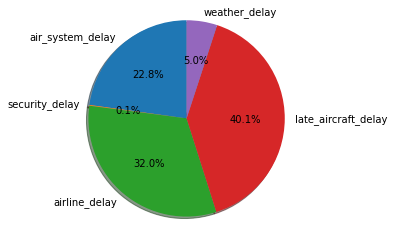

In [9]:
labels = 'air_system_delay', 'security_delay', 'airline_delay',\
         'late_aircraft_delay', 'weather_delay'

sizes = delaySums.iloc[0].astype(int).values.tolist()


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

Index:
```sql
CREATE index idx_delays on delays (security_delay, airline_delay, late_aircraft_delay, weather_delay);
```

## 2.Aufgabe

In [10]:
# most delays in states
state_delay_query = "select avg(departure_delay), origin_state\
                   from delays, flight\
                   where delays.FLIGHT_ID = flight.FLIGHT_ID\
                   group by origin_state"
state_delay = run_query(state_delay_query)
state_delay.sort_values(by=["AVG(DEPARTURE_DELAY)"], ascending = False).head()

,AVG(DEPARTURE_DELAY),ORIGIN_STATE
36,29.391753,DE
29,16.647590,GU
6,15.102804,AS
24,13.642984,IL
1,13.535258,NJ


Index:

```sql
CREATE INDEX IDX_DFLIGHT_ID ON delays(FLIGHT_ID)
CREATE INDEX IDX_FFLIGHT_ID ON flight(FLIGHT_ID)
```

![Average Delay by State](avg_delay_state.png)

In [4]:
#most delays at airports
AirportDelayQuery = "select avg(departure_delay), airport.airport \
                     from delays, airport\
                     where delays.ORIGIN_AIRPORT = airport.IATA_CODE\
                     group by airport.airport"
AirportDelay = run_query(AirportDelayQuery)
AirportDelay.sort_values(by=["AVG(DEPARTURE_DELAY)"], ascending = False).head()
AirportDelay

,AVG(DEPARTURE_DELAY),AIRPORT
0,4.450431,Bishop International Airport
1,9.585801,Fort Wayne International Airport
2,8.749528,Gainesville Regional Airport
3,1.280682,Range Regional Airport (Chisholm-Hibbing Airport)
4,2.698019,Honolulu International Airport
...,...,...
317,11.528820,Dallas/Fort Worth International Airport
318,7.762671,Dothan Regional Airport
319,1.210641,Dickinson Theodore Roosevelt Regional Airport
320,9.261006,Chippewa Valley Regional Airport


Index:
```sql
CREATE INDEX IDX_airport ON delays(ORIGIN_AIRPORT))
CREATE INDEX IDX_iata ON airport(IATA_CODE))
```

![Average Delay by Airport](avg_delay_airport.png)

## Aufgabe 5

In [14]:
AirlineWithMostFlightsQuery = "select   airline_iata, (100. * count(flight_ID) / sum(count(flight_ID)) over()) prop_delays \
from delays \
group by airline_iata"

AirlineWithMostFlights = run_query(AirlineWithMostFlightsQuery)
AirlineWithMostFlights

,AIRLINE_IATA,PROP_DELAYS
0,EV,9.867956
1,AS,2.963749
2,AA,12.163983
3,US,3.726203
4,F9,1.551405
5,VX,1.058316
6,WN,21.701837
7,DL,15.007366
8,B6,4.596648
9,HA,1.313167


Index:
```sql
CREATE INDEX SUMS ON delays(count(flight_ID))
```

![Most flights by airport](anteil_fluege.png)

In [18]:
AirlineWithMostDelayQuery = "select   airline_iata, 100. * avg(departure_delay) / sum(avg(departure_delay)) over() delay \
from delays \
group by airline_iata"

AirlineWithMostDelay = run_query(AirlineWithMostDelayQuery)
AirlineWithMostDelay.sort_values(by=["DELAY"], ascending= False)

,AIRLINE_IATA,DELAY
13,NK,12.661070
12,UA,11.483552
4,F9,10.828054
8,B6,8.976837
6,WN,8.344413
10,MQ,8.109277
2,AA,7.081262
5,VX,6.990444
0,EV,6.888562
11,OO,6.208781


Index:
```sql
CREATE INDEX SUMS ON delays(avg(departure_delay))
```

![Most Delay by Airline in Percentage](delay_airline.png)

## Aufgabe 7

In [25]:
query = """
SELECT ORIGIN_CITY, c FROM
(SELECT  ORIGIN_CITY, count(DISTINCT origin_airport) as c
    FROM flight GROUP BY ORIGIN_CITY)
WHERE c > 1
"""
df = run_query(query)
df

,ORIGIN_CITY,C
0,Columbia,2
1,Portland,2
2,Jacksonville,2
3,San Diego,2
4,Springfield,2
5,New York,2
6,Rochester,2
7,Jackson,2
8,Chicago,2
9,Albany,2


Index:
```sql
create index count_airports on count(distinct origin_airport)
```

![Cities with more then 1 airport](count_thing.png)

In [26]:
query = """
SELECT ORIGIN_STATE, c FROM
(SELECT  ORIGIN_STATE, count(DISTINCT origin_airport) as c
    FROM flight GROUP BY ORIGIN_STATE)
WHERE c > 1
ORDER BY c DESC
"""
df = run_query(query)

,ORIGIN_STATE,C
0,TX,24
1,CA,22
2,AK,19
3,FL,17
4,MI,15
5,NY,14
6,CO,10
7,NC,8
8,ND,8
9,MN,8


Index:
```sql
create index count_airports on count(distinct origin_airport)
```

![Count Airports by State](airpots_state.png)

## Aufgabe 8

In [29]:
query = """
SELECT route, airline_count, o origin, d destination
FROM
    (SELECT
    route, count(DISTINCT airline_iata) as airline_count, o, d
    FROM
        (SELECT   airline_iata, 
        origin_airport || ' ' || destination_airport as route, origin_airport o, destination_airport d
        FROM delays)
    GROUP BY route, o, d)
WHERE airline_count > 3

"""
df = run_query(query)
df #alle über 7

,ROUTE,AIRLINE_COUNT,ORIGIN,DESTINATION
0,ORD IAH,4,ORD,IAH
1,IAH ORD,4,IAH,ORD
2,CLT ATL,4,CLT,ATL
3,PHX ORD,5,PHX,ORD
4,MSY IAH,4,MSY,IAH
...,...,...,...,...
395,IAD DTW,4,IAD,DTW
396,ORD IAD,4,ORD,IAD
397,LAS ORD,4,LAS,ORD
398,IAH DEN,5,IAH,DEN


Index:
```sql

Create index route on origin_airport || ' ' || destination_airport
create index airline_count on count(distinct airline_iata)
```

![](routes.png)

## Aufgabe 9

In [23]:
query = """
SELECT airline_iata, 
sum(delay5) / count(airline_iata) * 100 "< 5 Min", 
sum(delay5_45) / count(airline_iata) * 100 "5 < 45 min", 
sum(delay45) / count(airline_iata) * 100 "> 45 Min"

FROM
    (SELECT airline_iata, sum_delay,
    CASE
        WHEN sum_delay < 5  OR  sum_delay is NULL THEN 1
        ELSE 0
    END AS delay5,
    CASE
        WHEN  45 > sum_delay AND sum_delay > 5 THEN 1
        ELSE 0
    END AS delay5_45,
    CASE
        WHEN  45 < sum_delay THEN 1
        ELSE 0
    END AS delay45
    FROM
        (SELECT airline_iata,
        air_system_delay + security_delay + airline_delay + late_aircraft_delay + weather_delay as sum_delay
        FROM delays))
GROUP BY airline_iata
"""
df = run_query(query)
df

,AIRLINE_IATA,< 5 Min,5 < 45 min,> 45 Min
0,EV,80.526899,10.639640,8.656739
1,AS,86.900680,8.745745,4.235894
2,AA,81.485878,10.861361,7.481956
3,US,81.607327,11.811891,6.413205
4,F9,72.946153,14.374811,12.399831
5,VX,80.695973,11.091621,8.005103
6,WN,80.630740,11.917943,7.259498
7,DL,85.988012,8.316830,5.577831
8,B6,77.498113,12.037041,10.249454
9,HA,88.496359,9.108953,2.307582


Index: 
```sql
create index sum_delay on air_system_delay + security_delay + airline_delay + late_aircraft_delay + weather_delay
```

![Anteil Verspätungen](anteil_delays.png)